In [1]:
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import requests
import json
import datetime
from textblob import TextBlob
from selenium import webdriver
import time

In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\deark\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\deark\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
plt.style.use('dark_background')

In [5]:
stock_tags = ['ACGL',
              'ADM',
              'AFL',
              'ALL',
#             'ALXN',
#              'ANTM',
#              'BBL',
#              'BHP',
#             'BLK',
#              'BNS',
#              'BSBR',
#              'BTI',
#             'CB',
#              'CBRE',
#              'CI',
#              'CINF',
#             'DAL',
#              'DGX',
#              'DHI',
#              'EC',
#              'EQR',
#             'ESS',
#              'FITB',
#              'FMX',
#              'FOXA',
#             'FTV',
#              'GD',
#              'GOLD',
#              'HIG',
#             'INFO',
#              'JCI',
#              'L',
#              'LH',
#              'LHX',
             'MAA'
             ]

In [6]:
def get_ticker():

    #gets symbol from user
    g = input("Please Enter Ticker Symbol: ")
    return g

In [7]:
def get_sentiment(stock_name):

    #declare variables
    json_sentiment = {}
    Bullish = 0
    Bearish = 0
    totalcounter = 0

    #calls get_ticker function and creates stocktwits web address for that symbol
    website = ('https://stocktwits.com/symbol/' + stock_name )

    #selenium requires webdrivers to perform in certain browers. In this case we are using Chrome and the webdriver
    #needed for this is chromedriver.exe
    #the driver variable is set as the chrome webdriver .exe program
    driver = webdriver.Chrome('chromedriver_win32/chromedriver.exe')

    #FireFox webdriver then open up the website that we declared in line 23
    driver.get(website)

    #scroll down to allow more comments to be scrapped
    for i in range(20):
        driver.execute_script("window.scrollTo(0,40000)")
        time.sleep(.2)


    comment = {}

    #uses html class name to find all comments and sentiments
    el = driver.find_elements_by_class_name('st_3SL2gug')
    le = driver.find_elements_by_class_name('st_11GoBZI')

    #finds number of comment and sentiments extracted
    length_el = len(el)
    length_le = len(le)

    #converts webelement list to regular list for easy access of data
    for i in range(length_el):
        comment[i] = el[i].text
    for i in range(length_le):
        json_sentiment[i] = le[i].text

    #adds comments that are Bullish or Bearish into corresponding counters
    for i in json_sentiment:
        if ((json_sentiment[i])) == 'Bearish':
            json_sentiment[i] = 'Bearish'
            Bearish += 1
            totalcounter += 1
        elif ((json_sentiment[i])) == ('Bullish'):
            json_sentiment[i] = 'Bullish'
            Bullish += 1
            totalcounter += 1

    total = Bearish + Bullish

    driver.close()

    #prints percentage of Bullish or Bearish comments           
    #print('Percent Bullish')
    #print((Bullish/total)*100)
    #print('\nPercent Bearish')
    #print((Bearish/total)*100)

    #print('\n')
    #print('Total Counter')
    #print(totalcounter)
    
    
    polarityShift = 0;

    negative_keywords = ['bear','loss','losing','low','hit','tumble','fell','fall','hurt',
                         'recession','worse','drop','down','dip','die','red','over']

    positive_keywords = ['bull','earn','gain','high','great','diversification','buy','merge',
                         'recover','jump','bounce','rebound','surge','like','green']

    total_sentiment = 0;

    for i in range(len(comment)):
        blob = TextBlob(comment[i])
        for sentence in blob.sentences:
            polarityShift = 0

            for word in negative_keywords:
                if sentence.find(word.lower())!= -1:
                    polarityShift-=.3

            for word in positive_keywords:
                if sentence.find(word.lower())!= -1:
                    polarityShift+=.3

            total_sentiment+= sentence.sentiment.polarity + polarityShift;

            #print("tweet# " + str(i))
            #print(sentence)
            #print("Score: " + str(sentence.sentiment.polarity + polarityShift))
            #print()

        #print("-----------------------------")


    #print('\n\n')
    #print('Overall sentiment ' + str(total_sentiment/len(comment)))
    
    weighted_average = .5 * ((Bullish/total-Bearish/total))  +  .5 * (total_sentiment/len(comment))
    #print('weighted average: ' + str(weighted_average))
    
    return ((Bullish/total-Bearish/total)), (total_sentiment/len(comment))

In [8]:
def get_graph(stock_name, start_load, end_load, start_fib, end_fib, sentiment_adjust):
    #stock_name is the stock symbol
    #start_load is the date you start loading data from
    #end_load is the dat you end loading data from
    #start_fib is the begining date you start looking for max and mins for when doing fibonacci retracement
    #end_fib is the begining date you start looking for max and mis for when doing fibonacci retracement
    
    #getting the stock data into a dataframe
    df = web.DataReader(stock_name, data_source = 'yahoo', start = start_load, end = end_load)
    
    

    #Printing the starting and ending values of the dataframe
    print('Starting: ' + str(df['Close'][0]))
    print('Ending:   ' + str(df['Close'][len(df)-1]))
    
    #The sentiment adjustment only happens if the value we found does not match the data (positive sent. but stock price drop etc.)
    #Here we adjust the last three weeks of stock values in order to model sentiment data provided by Stockwits
    #We take the sentiment score, x, and adjust the return of each day of the last three weeks by x% to find the new return
    #If sentiment adjustment data is not provided, we assume 0, meaning no actual change happens to the data
    
    if (df['Close'][len(df)-1] - df['Close'][len(df)-21]) * sentiment_adjust < 0:
        
        print("\nTrend and sentiment don't match so stock data for the last three weeks will be adjusted\n")
        
        for i in range(len(df)-1, len(df)-14, -1):

            if sentiment_adjust >= .5: sentiment_adjust = sentiment_adjust ** 1.5
            daily_return = df['Close'][i] / df['Close'][i-1]
            adj_daily_return = daily_return + sentiment_adjust**2
            df['Close'][i] = df['Close'][i-1] * adj_daily_return
    
    
    #plotting the actual stock data COMMENT NEXT LINE IF YOU WANT TO REMOVE ACTUAL STOCK DATA
    df['Close'].plot(figsize=(16,6), color='blue')
    #Taking a rolling mean of 10 for trend lines
    df_average = df['Close'].rolling(10).mean()
    #plotting this rolling mean of the data  COMMENT NEXT LINE IF YOU WANT TO REMOVE ROLLING MEAN
    df_average.plot(figsize=(16,6), color='cyan')
    
    #creating new dataframe for trendlines
    df_trend = df['Close'].copy()
    #clearing dataframe except for initial and final values, which are given points on the trend line
    for i in range(1,len(df_trend)-1):
        df_trend[i]=0
    
    #plotting the edges of the region in which fibonacci retracement max and mins are searched for
    plt.axhline(y=(np.max(df['Close'][start_fib:end_fib])), color='r')
    plt.axhline(y=(np.min(df['Close'][start_fib:end_fib])), color='r')

    #finding the stock minimum in the given region
    stock_min = np.min(df['Close'][start_fib:end_fib])
    
    #finding the range between the maximum and minimum in the given region
    stock_range = np.max(df['Close'][start_fib:end_fib] - np.min(df['Close'][start_fib:end_fib]))
    
    #trnd_dst is the trend distance, a variable that measures how far measurments will be take to find changes in stock direction
    trnd_dst = round(len(df_average)/40)

    #i is the initial point from which we will look to find trend lines
    i=10
    while i < len(df_average)-(trnd_dst*2):
        #go through every point and see if the difference in distance from it the points around it, trnd_dst away is large
        #if it is large enough and crosses a certain threshhold (stock_range*.1), we can create a new trend line for the region
        if abs((df_average[i]-df_average[i+trnd_dst])-(df_average[i+trnd_dst]-df_average[i+(trnd_dst*2)])) > stock_range*.05:
            #plt.axvline(x=df_average.index[i+trnd_dst], color='g')
            #plt.axvline(x=df_average.index[i+(trnd_dst*2)], color='r')
            
            #adding the new trend change to our dataframe
            df_trend[i] = df_average[i]

            i+=(trnd_dst*2)
        else:
            i+=1
            
    #clear all points that aren't 0, ie make dataframe only contain days where trend lines change
    df_trend = df_trend[df_trend > 0]
    #plot the trend lines COMMENT NEXT LINE IF YOU WANT TO GET RID OF TREND LINES
    plt.plot(df_trend, color='w')
    
    #mid represents the different fibonacci retracement levels in proportion to the min and max of our given region
    mid = [
        stock_range * .236 + stock_min,
        stock_range * .382 + stock_min,
        stock_range * .500 + stock_min,
        stock_range * .618 + stock_min,
        stock_range * .786 + stock_min
            ]
    
    mid_score = [0,0,0,0,0]
    
    mid_reversals = [0,0,0,0,0]
    
    #plot each fibonacci retracement level COMMENT NEXT TWO LINES IF YOU WANT TO GET RID OF FIBONACCI LINES
    for fib_line in mid:
        plt.axhline(y=fib_line, color='g')

    #for each value of our stock, check if it is relative to the stock value, close to a fibonacci retracement line
    #if it is, check if the values to its left and right indicate if it crosses the line, or reverses direction
    #if it does, mark a vertical line there as a possible indicator of a resistance or support level
    #do this for all retracement lines, and break the loop if a reversal is found
    for i in range(3,len(df)-3):
        for j in range(len(mid)):
            dist = df['Close'][i]-mid[j]
            dist_left = df['Close'][i-3]-mid[j]
            dist_right = df['Close'][i+3]-mid[j]
    
            if abs(dist) < stock_range*.02 and (dist-dist_right)*(dist-dist_left)>0:

                #plt.axvline(x=df.index[i], color='C'+str(j))
                mid_reversals[j]+= 1
                mid_score[j]+= (abs(dist-dist_left) + abs(dist-dist_right))/stock_range
                break
    
    #Count the number of days your data spans
    num_days = (df.index[len(df)-1]-df.index[0]).days
    #Print the number of days your data spans
    print('Days:     ' + str(num_days))
    
    df_values = df_trend[:len(df_trend)-1].copy()
    df_dates = df_trend[:len(df_trend)-1].copy()
    for i in range(len(df_trend)-1):
        #df_return['Days Since'][i] = (df_return.index[i]-df_trend.index[0]).days
        df_values[i] = (df_trend[i+1]/df_trend[i] -1) * (num_days/((df_trend.index[i+1]-df_trend.index[i]).days+2))
        df_dates[i] =  (df_trend.index[i]-df_trend.index[0]).days
    
    #Plot the regions in which fibonacci retracement is performed
    plt.axvline(x=start_fib, color='w')
    plt.axvline(x=end_fib, color='w')
    
    plt.show()
    
    print('Mid Reversals: ' + str(mid_reversals))
    print('Mid Score    : ' + str(mid_score))
    
    return df['Close'][0], num_days, df_values, df_dates
    

In [9]:
def get_monte(initial, numSteps, numExtra, values, dates, numSims, lowPercentile, highPercentile, chance_value):
    #initial is the initial value of the stock from the starting day data was collected from
    #numSteps is the number of days the monte carlo simulation will last (normally range of collected stock data)
    #numExtra is the added number of days we will simulate past the range of stock data
    #values is the list of different data trends for the stock
    #dates is the list of days where the trend goes from one value to the next
    #numSims is the number of Monte Carlo Simulations you want to perform
    #lowPercentile is the lower percentile whose value you want to measure
    #highPercentile is the higher percentile whose value you want to measure
    
    #assigning the total number of simulation steps
    total = numSteps + numExtra
    
    #volatility is an array measuring the stock volatility over the whole time period
    volatility = np.ndarray(shape=(total))
    
    #for each of the values in the array, set them to a certain volatility (can be modified to take real stock volatility)
    for i in range(0,total):
        if i < 50:
            volatility[i] = .2
        elif i < 60:
            volatility[i] = .2
        else:
            volatility[i] = .2

    #stockReturn is an array that represents the stock volatility over the whole time period
    stockReturn = np.ndarray(shape=(total))
    
    #for each of the values in the array, set them to the return calculated from our analysis given values and dates
    for i in range(0,total):
        
        for j in range(1,len(dates)):
            if i <= dates[j]:
                stockReturn[i] = values[j-1]
                break
            elif i > dates[len(dates)-1]:
                stockReturn[i] = values[len(values)-1]
            
    #array of calculated values of the monte carlo simulation
    y = np.ndarray(shape=(total,numSims), dtype=float)

    #an array that holds a modified version of the y array that has greater stock variability
    y_non_rolling = np.ndarray(shape=(total, numSims), dtype=float)

    #perform the monte carlo simulation
    for j in range(0,numSims):
        y[0][j]=initial
        y_non_rolling[0][j] = initial
        for i in range(1,total):
            y[i][j] = y[i-1][j] + (y[i-1][j] * ((stockReturn[i]/total)+((volatility[i]/50) * np.random.normal())))
            y_non_rolling[i][j] = y[i][j] + (y[i][j] * volatility[i]/5 * np.random.normal())
        
    #plot the monte carlo simulation
    plt.figure(figsize=(16, 6))
    plt.suptitle('Monte Carlo: ' + str(numSims) + ' Lines, ' + str(total) + ' Steps, ' + str(volatility[0]*100) +
                 '% init. volatility')
    plt.xlabel ('Time Step')
    plt.ylabel ('Asset Price')
    plt.xlim(-total/100,total+total/100)
    
    #plt.plot(y_non_rolling, color='blue')
    plt.plot(y)
    
    #Line seperating known stock data and future stock data
    plt.axvline(x=numSteps, color='g')
    plt.axhline(y=chance_value, color='g')
    
    #plt.savefig('MonteCarlo.png', dpi=500)
    plt.show()
    
    #plot a histogram of the final position of the array ie the final values
    plt.hist(y[len(y)-1], bins='auto')
    #plt.savefig('Histogram.png', dpi=500)
    plt.show()
    
    #print relevant statistics
    print("Mean:   " + str(np.mean(y[total-1])))
    print("Median: " + str(np.median(y[total-1])))
    print(str(lowPercentile) + "%ile: " + str(np.percentile(y[total-1], lowPercentile)))
    print(str(highPercentile) + "%ile: " + str(np.percentile(y[total-1], highPercentile)))
    
    inv_percentile(y[len(y)-1], chance_value)


In [10]:
def inv_percentile(array, value):
    percentile = len(array[value > array])/len(array)
    print('\nPercentile of ' + str(value) + ': ' + str(percentile))
    print('    Chance of ' + str(value) + ': ' + str(1-percentile))
    return percentile

In [11]:
def analyze_and_monte(stock_name, start_load, end_load, start_fib, end_fib, numExtra, numSims,
                      lowPercentile, highPercentile, chance_value, find_sentiment):
    
    
    print("Stock Analysis (" + stock_name + "): \n")
    
    if find_sentiment:
        sentiments = get_sentiment(stock_name)
    
        print('Bear v Bull / NLP Sentiments:' + str(sentiments))
        sentiment_adjust = .5 * sentiments[0] + .5 * sentiments[1]
        print('Weighted sentiment: ' + str(sentiment_adjust))
    
    else: sentiment_adjust = 0
    
    #perform analysis on the stock and display al relevant data, while pulling everything we need for monte carlo
    initial, numDays, df_values, df_dates = get_graph(stock_name, start_load, end_load, start_fib, end_fib, sentiment_adjust)
    
    print("\nMonte Carlo Simulation: \n")
    
    #perform the monte carlo and also display relevant statistics
    if(chance_value > 0):
        get_monte(initial, numDays, numExtra, df_values, df_dates, numSims, lowPercentile, highPercentile, chance_value)
    else:
        get_monte(initial, numDays, numExtra, df_values, df_dates, numSims, lowPercentile, highPercentile, initial)
    
    print('\n\n')

Stock Analysis (SFET): 

Bear v Bull / NLP Sentiments:(0.9230769230769231, 0.08870518154684817)
Weighted sentiment: 0.5058910523118857
Starting: 3.0399999618530273
Ending:   1.7999999523162842
Days:     182


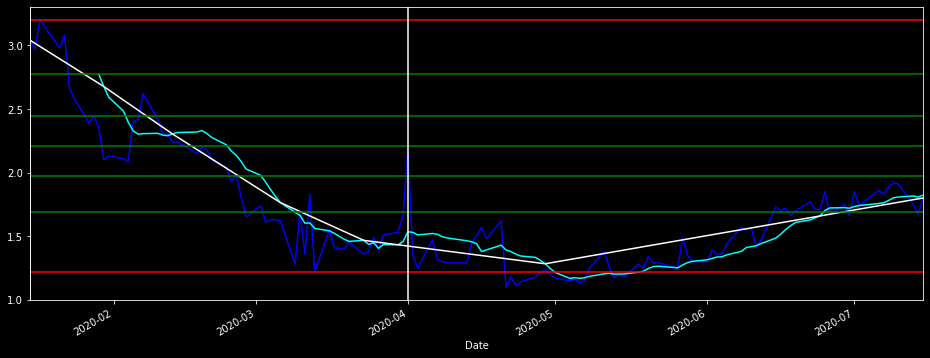

Mid Reversals: [6, 0, 1, 2, 0]
Mid Score    : [1.0252528019601377, 0, 0.6969697480541793, 0.31313149314329847, 0]

Monte Carlo Simulation: 



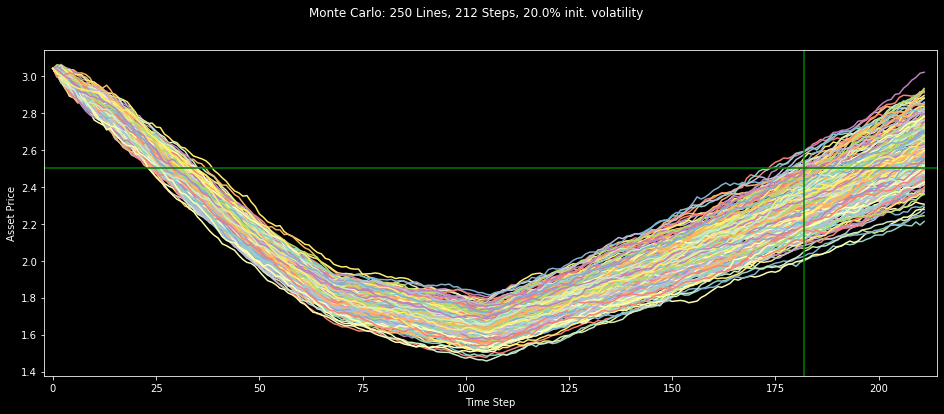

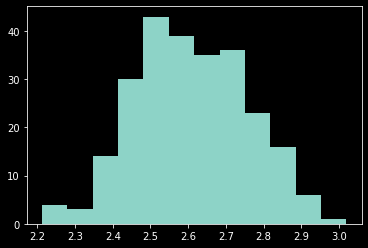

Mean:   2.608092759808691
Median: 2.6011711081016404
25%ile: 2.502940597243188
75%ile: 2.717630527148715

Percentile of 2.5: 0.228
    Chance of 2.5: 0.772





In [19]:
analyze_and_monte('SFET', '2020-1-15','2020-7-15','2020-1-15','2020-4-1', 30, 250, 25, 75, 2.5, True)

Stock Analysis (JWN): 

Bear v Bull / NLP Sentiments:(0.4166666666666667, 0.07928962429353059)
Weighted sentiment: 0.24797814548009864
Starting: 32.470001220703125
Ending:   15.149999618530273

Trend and sentiment don't match so stock data for the last three weeks will be adjusted

Days:     380


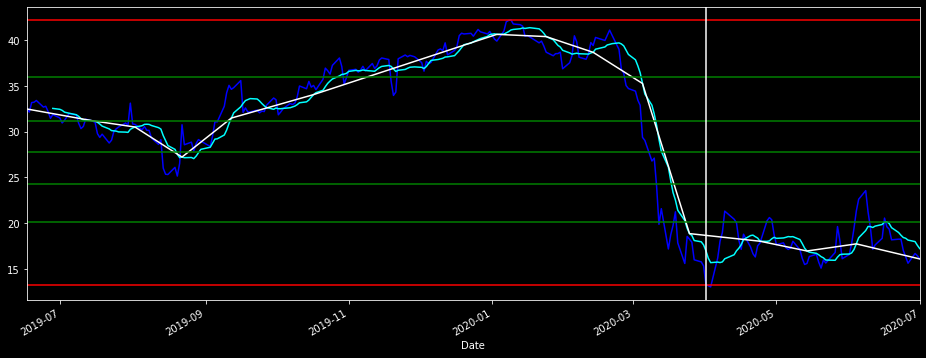

Mid Reversals: [8, 0, 1, 9, 4]
Mid Score    : [1.3961298035997056, 0, 0.13628503718026716, 0.6561744241577079, 0.4863368097196795]

Monte Carlo Simulation: 



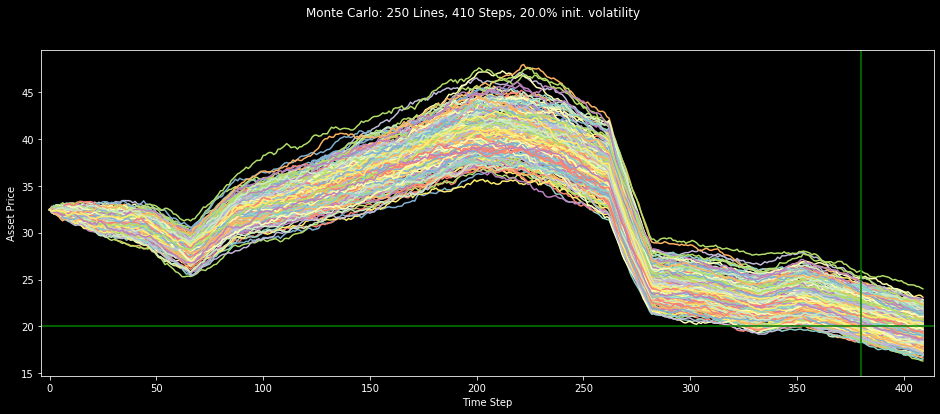

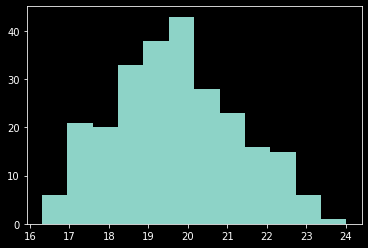

Mean:   19.677619693980063
Median: 19.62373956116969
25%ile: 18.592914229962382
75%ile: 20.718807141260463

Percentile of 20: 0.604
    Chance of 20: 0.396





In [12]:
analyze_and_monte('JWN', '2019-6-15','2020-7-1','2019-6-15','2020-4-1', 30, 250, 25, 75, 20, True)

Stock Analysis (SKT): 

Starting: 16.520000457763672
Ending:   7.130000114440918
Days:     379


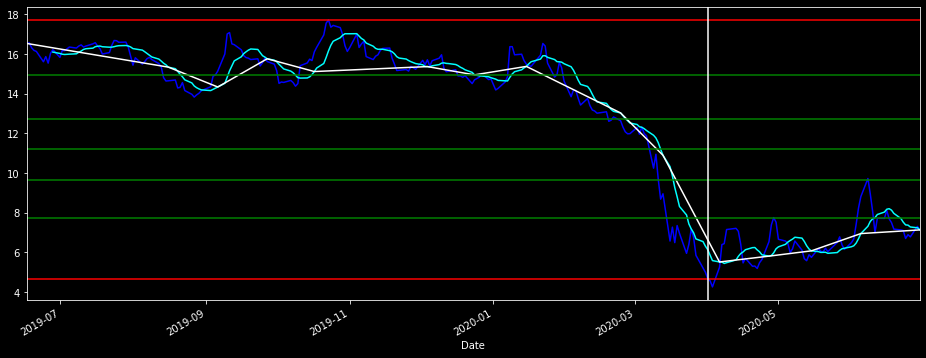

Mid Reversals: [2, 1, 0, 2, 8]
Mid Score    : [0.40982351937388023, 0.38603230804311617, 0, 0.09516491851372155, 0.4428241657572421]

Monte Carlo Simulation: 



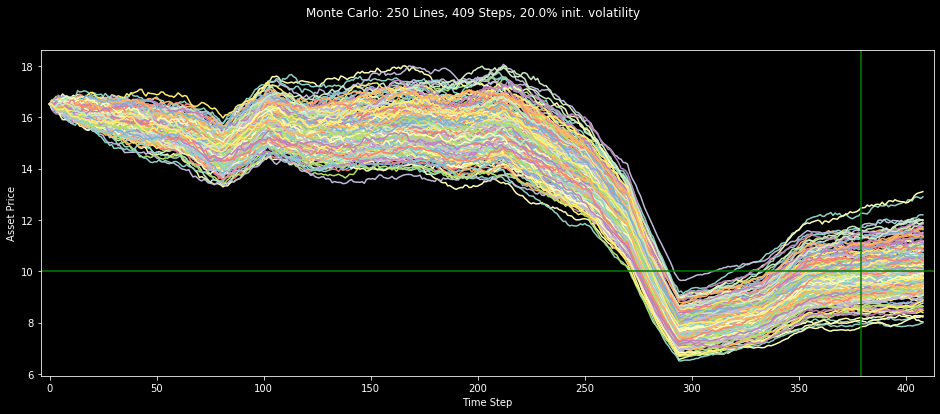

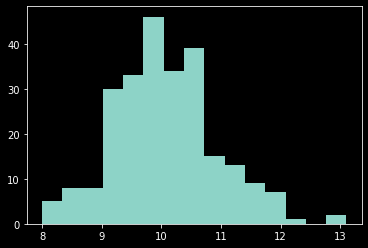

Mean:   10.071672598142063
Median: 9.991891595619226
25%ile: 9.44575586937571
75%ile: 10.540399954463687

Percentile of 10: 0.508
    Chance of 10: 0.492





In [13]:
# for stock in stock_tags:
#     analyze_and_monte(stock, '2019-6-15','2020-6-15','2019-6-15','2020-4-1', 15, 100, 25, 75, 0, 0.5)

analyze_and_monte('SKT', '2019-6-15','2020-6-30','2019-6-15','2020-4-1', 30, 250, 25, 75, 10, False)

Stock Analysis (IHRT): 

Bear v Bull / NLP Sentiments:(0.8383838383838385, 0.09547577711640212)
Weighted sentiment: 0.4669298077501203
Starting: 15.399999618530273
Ending:   9.829999923706055
Days:     360


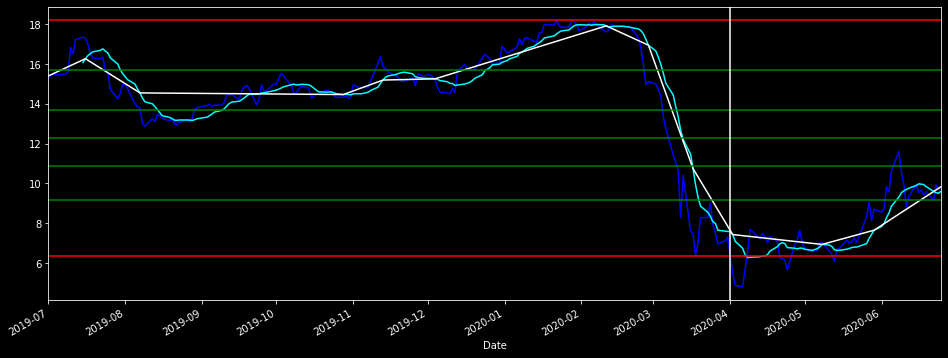

Mid Reversals: [4, 0, 0, 1, 5]
Mid Score    : [0.7676768925499569, 0, 0, 0.07575762927465678, 0.4696970767311317]

Monte Carlo Simulation: 



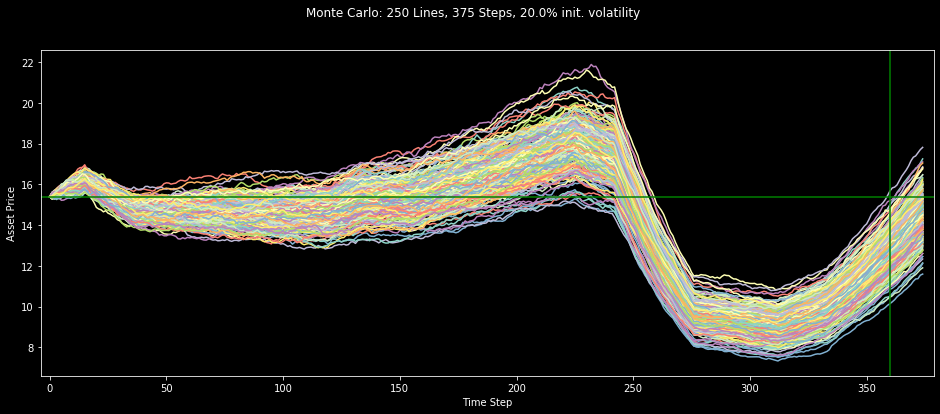

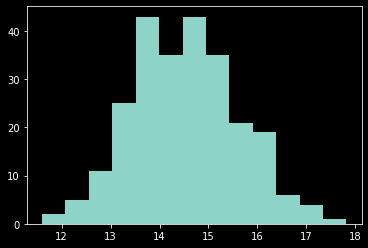

Mean:   14.53417252241911
Median: 14.508105337274372
25%ile: 13.784311045824062
75%ile: 15.293781125350847

Percentile of 15.399999618530273: 0.788
    Chance of 15.399999618530273: 0.21199999999999997





In [20]:
analyze_and_monte('IHRT', '2019-6-25','2020-6-25','2019-6-15','2020-4-1', 15, 250, 25, 75, 0, True)

Stock Analysis (TSLA): 

Bear v Bull / NLP Sentiments:(0.3442622950819672, 0.1120131134829411)
Weighted sentiment: 0.22813770428245417
Starting: 430.260009765625
Ending:   990.9000244140625
Days:     165


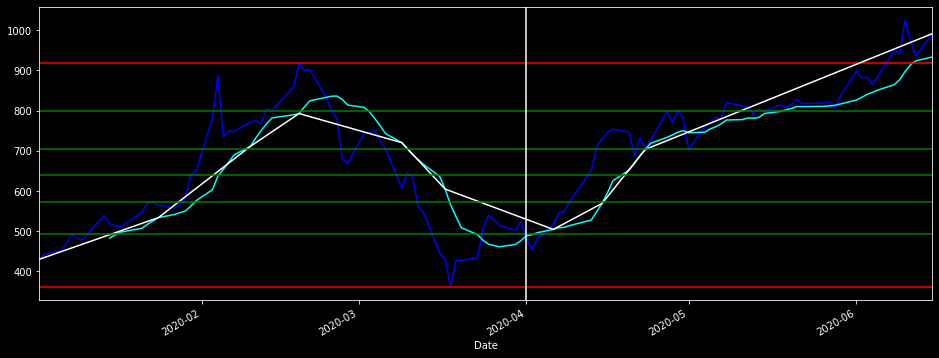

Mid Reversals: [1, 3, 0, 2, 7]
Mid Score    : [0.12132323389112687, 0.40197764008471404, 0, 0.4553757220422461, 0.7461702824950079]

Monte Carlo Simulation: 



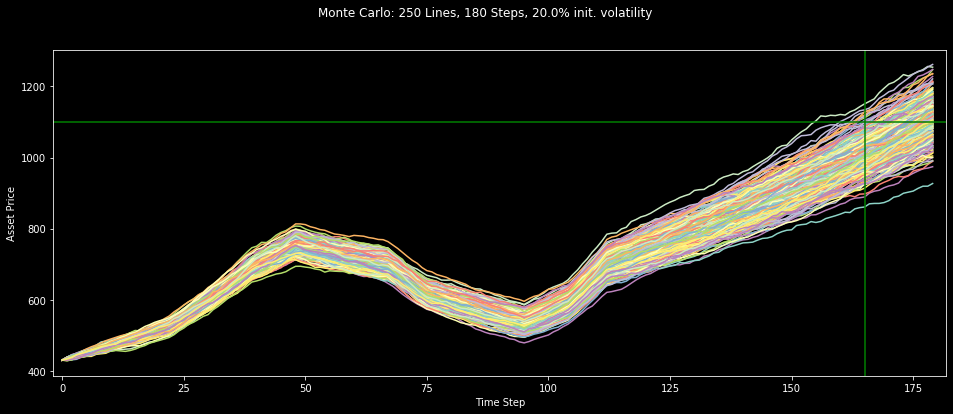

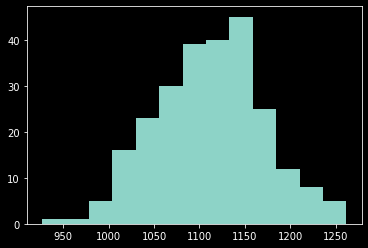

Mean:   1111.8133569464012
Median: 1114.155110094748
25%ile: 1066.8512188970908
75%ile: 1153.5203309093813

Percentile of 1100: 0.416
    Chance of 1100: 0.5840000000000001





In [64]:
analyze_and_monte('TSLA', '2020-1-1','2020-6-15','2020-1-1','2020-4-1', 15, 250, 25, 75, 1100, True)

Stock Analysis (ACGL): 

Bear v Bull / NLP Sentiments:(1.0, 0.028035714285714303)
Weighted sentiment: 0.5140178571428572
Starting: 35.90999984741211
Ending:   28.8799991607666

Trend and sentiment don't match so stock data for the last three weeks will be adjusted

Days:     366


C:\Users\deark\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


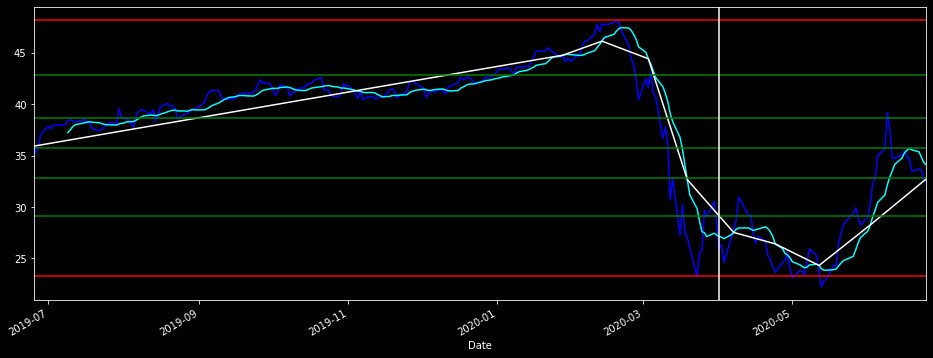

Mid Reversals: [5, 0, 2, 10, 7]
Mid Score    : [0.8739966615275918, 0, 0.27234156546887806, 0.5136431682897628, 0.6665329277487615]

Monte Carlo Simulation: 



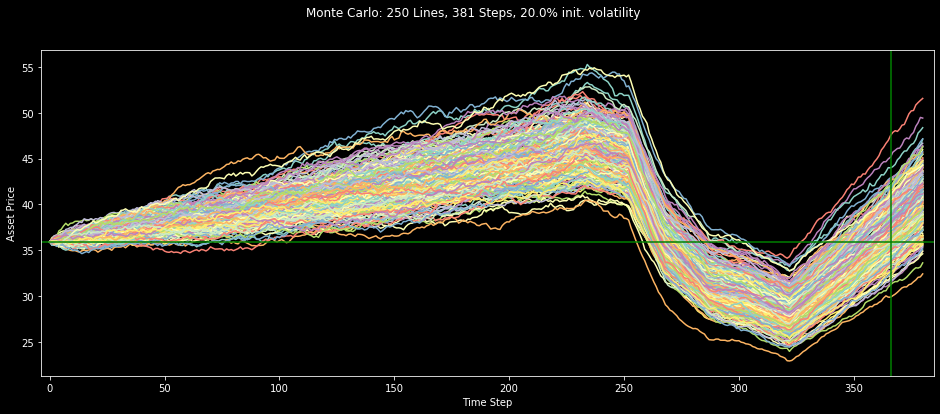

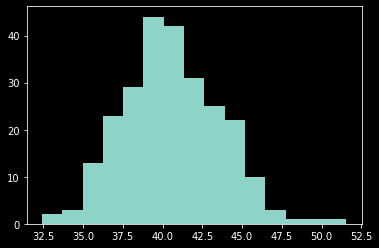

Mean:   40.577515033522246
Median: 40.4958233380409
25%ile: 38.52228227170348
75%ile: 42.68327572173951

Percentile of 35.90999984741211: 0.06
    Chance of 35.90999984741211: 0.94





In [21]:
analyze_and_monte('ACGL', '2019-6-25','2020-6-25','2019-6-15','2020-4-1', 15, 250, 25, 75, 0, True)

Stock Analysis (CMLS): 

                 High        Low       Open      Close   Volume  Adj Close
Date                                                                      
2019-06-25  17.200001  16.850000  17.139999  16.920000    79400  16.920000
2019-06-26  17.667999  16.670000  17.320000  17.170000    67000  17.170000
2019-06-27  17.750000  17.080000  17.299999  17.600000    94800  17.600000
2019-06-28  19.180000  17.360001  17.830000  18.549999  1722000  18.549999
2019-07-01  18.790001  17.700001  18.570000  18.570000   216700  18.570000
...               ...        ...        ...        ...      ...        ...
2020-06-19   5.820000   5.300000   5.820000   5.340000   322300   5.340000
2020-06-22   5.340000   4.850000   5.260000   4.870000   384800   4.870000
2020-06-23   5.110000   4.600000   4.960000   4.750000   323700   4.750000
2020-06-24   4.590000   4.100000   4.570000   4.290000   646200   4.290000
2020-06-25   5.250000   4.410000   5.250000   4.630000  1114300   4.630000


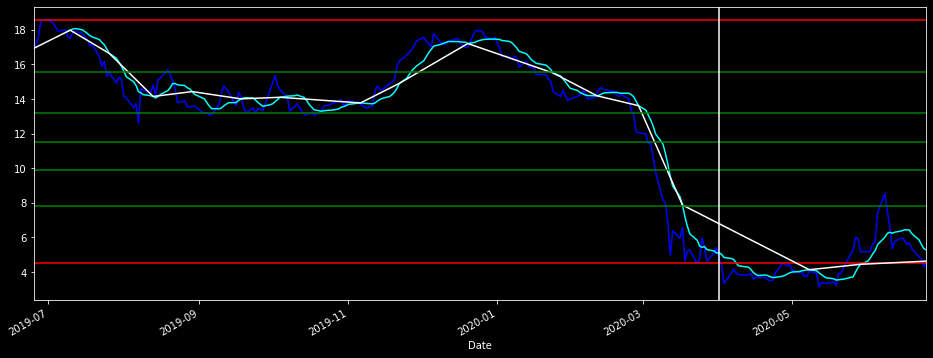

Mid Reversals: [0, 0, 0, 9, 3]
Mid Score    : [0, 0, 0, 0.7839375213848084, 0.5508174215899398]

Monte Carlo Simulation: 



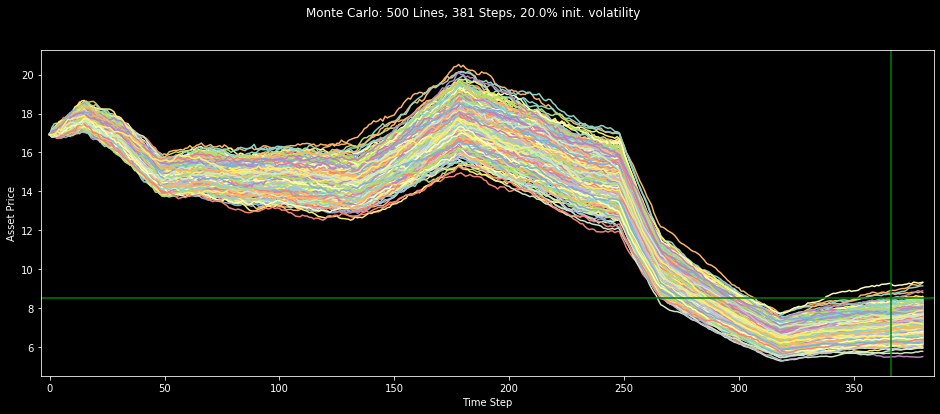

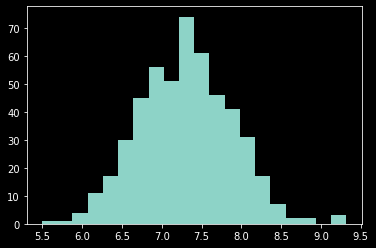

Mean:   7.299905218453229
Median: 7.307252154048044
25%ile: 6.896870965923408
75%ile: 7.67376551976945

Percentile of 8.5: 0.98
    Chance of 8.5: 0.020000000000000018





In [12]:
analyze_and_monte('CMLS', '2019-6-25','2020-6-25','2019-6-15','2020-4-1', 15, 500, 25, 75, 8.5, True)